# The Andersen Thermostat

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100

from matplotlib.animation import FuncAnimation

from numba import njit   # Import this if you're using @njit to speed up your code
from tqdm import tqdm    # This is a very cool package that allows you to see a "progress bar" to know how far a loop has progressed

In [2]:
@njit
def lj_acc(rij):
    '''
    Get the 2D Lennard-Jones acceleration of two masses seperated by a distance rij.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    
    Returns:
    --------
    The function returns one value:
    • a : A numpy array 2 elements storing the `x` and `y` components of the acceleration.
    '''
    
    rsq = np.dot(rij,rij)    # Compute the squared distance as a dot product
    r6  = rsq*rsq*rsq        # Compute r**6
    
    f1 = 1/rsq               # Evaluate 1/r**2 and 1/r**6
    f2 = 1/r6
    
    a = 48 * f1 * f2 *( f2 - 0.5)*rij  # Evaluate the acceleration
    
    return a

@njit
def get_pe(step_pos,L):
    '''
    Get the 2D Lennard-Jones potential energy for a system of `N` masses.
    
    Parameters:
    -----------
    • pos : An `(N x 2)` numpy array of 2 elements storing the `x` and `y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • potential : The combined potential energy of the `N` masses.
    '''
    
    N = len(step_pos)                           # Total number of particles
    
    potential = 0.0                             # Total potential energy
    
    for p in range(N-1):                        # Loop over pairs of particles
        for q in range(p+1,N):
            rij = step_pos[p] - step_pos[q]     # Find the relative position vector of the pair
            
            rij = pbc_distance(rij)
            
            rijsquare = np.dot(rij,rij)         # Compute quantities needed for the PE      
            f2 = 1.0/rijsquare                  
            f6 = f2*f2*f2
            potential += 4.*f6*(f6-1.)          # Increment potential per pair of particles
            
    return potential

@njit
def get_ke(step_vel):
    '''
    Get the kinetic energy for a system of `N` masses.
    
    Parameters:
    -----------
    • vel : An `(N x 2)` numpy array of 2 elements storing the `v_x` and `v_y` values of each particle.
    
    Returns:
    --------
    The function returns one value:
    • kinetic : The combined kinetic energy of the `N` masses.
    '''

    kinetic = 0.5*np.sum(step_vel**2)
    
    return kinetic


@njit
def pbc_distance(rij):
    '''
    Get the correct distance between two particles, accounting for periodic boundary conditions.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    
    Returns:
    --------
    The function returns one value:
    • rij : The corrected rij, including the effects of periodic boundary conditions.
    '''
    
    for d in range(2):
        if abs(rij[d])>0.5*L:                    # Compute the _true_ distance, taking into account
            rij[d] -= L*np.sign(rij[d])          # periodic boundary conditions
    
    return rij

@njit
def maxwell(v,T):
    '''
    Maxwell-Boltzmann distribution of velocities in two-dimensions.
    
    Parameters:
    -----------
    • v    : Number or array of velocities
    • T    : Temperature at which the Maxwell-Boltzmann distribution is computed
    
    Returns:
    --------
    The function returns the probability density from the Maxwell-Boltzmann distribution:
    • p : If `v` is a numpy array, `p` is a numpy array. If `v` is a number, `p` is a number.
    '''

    p = (1./T)*v*np.exp(-0.5*v*v/T)
    
    return p

In [3]:
def init_pos(Lx, Ly, Nx, Ny):
    '''
    Assign the initial positions of the particles on a regular lattice.
    
    Parameters:
    -----------
    • Lx   : x-length of the lattice.
    • Ly   : y-length of the lattice.
    • Nx   : An integer number of particles in the x-direction.
    • Ny   : An integer number of particles in the y-direction.
    
    Returns:
    --------
    The function returns one value:
    • ipos : A numpy array of (N x 2) elements storing the `x` and `y` coordinates of `N = Nx * Ny` particles.
    '''

    N = Nx*Ny                                       # Total number of particles in the lattice
    
    dx = Lx/Nx                                      # Spacing between particles along the  
    dy = Ly/Ny                                      # x and y axes
    
    ipos = np.zeros((N,2))                          # Empty array to store positions

    n=0                                             # Counter to count the number of particles
    
    for x in range(Nx):                             # Loop over all particles
        for y in range(Ny):
            ipos[n] = [dx/2 + dx*x, dy/2 + dy*y]    # Assign positions to each particle
            n+=1                                    # Increment counter
    
    return ipos


def init_vel(N):

    '''
    Assign the initial velocities of the particles.
    
    Parameters:
    -----------
    • N    : An integer number of particles.
    
    Returns:
    --------
    The function returns one value:
    • ivel : A numpy array of (N x 2) elements storing the `x` and `y` velocity components of `N` particles.
    '''
    
    ivel = np.zeros((N,2), dtype=np.float32)         # Initialise the empty array for velocities 

    T = 0.5                                          # Initial "temperature" of the system
    T0 = 1                                           # Temperature scale of the problem

    v0 = np.sqrt(2*T/T0)                             # Initial speed of each particle

    for i in range(N):                               # Loop over each particle and 
        r = 2*np.pi*np.random.random()               # assign it a random direction
        ivel[i][0] = v0 * np.cos(r)                  # Set the x and y components of the velocity
        ivel[i][1] = v0 * np.sin(r)                  # while keeping the magnitude constant

    vcm = np.sum(ivel,axis=0)/N                      # Compute the centre of mass velocity
    ivel = ivel-vcm                                  # Subtract the COM velocity so the COM is stationary

    return ivel

In [4]:
@njit
def andersen_scaling(velocities, T, dt, collisionRate=0.1):
    '''
    Scale the array of velocities using Andersen scaling to simulate an Andersen thermostat.
    
    Parameters:
    -----------
    • velocities    : A numpy array of (N x 2) elements storing the `x` and `y` velocity components of `N` particles.
    • T             : The temperature of the thermostat.
    • dt            : The time-step of the simulation
    • collisionRate : Rate at which particles collide with thermostat. Depends on choice of `dt` and temperature `T`.
    
    Returns:
    --------
    The function returns one value:
    • velocities    : A numpy array of (N x 2) elements storing the new scaled `x` and `y` velocity components of `N` particles.
    '''

    N = len(velocities)                                              # Total number of particles
    for i in range(N):                                               # For each particle,
        if(np.random.random() < collisionRate*dt):                   # choose if it collides with the thermostat.
            
            # To choose the right velocities, we assume the distribution of velocities in each direction to be
            # a Gaussian with a mean of 0 and a standard deviation related to T as shown below. 
            # The choice of two Gaussian random numbers is done using the Box-Muller transformation. 
            # For more information, see here: https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform
            
            r1 = np.random.random()                                  # If it colloides, choose two random numbers, one
            r2 = np.random.random()*2*np.pi                          # between (0,1), and one between (0, 2 np.pi).
            
            velocities[i][0] = np.sqrt(-2*T*np.log(r1))*np.cos(r2)   # Draw the new velocity components from Gaussian
            velocities[i][1] = np.sqrt(-2*T*np.log(r1))*np.sin(r2)   # distributions of appropriate mean and stdev.

    return velocities

In [5]:
def simulate(ipos, ivel, set_T=None, tf=100, dt=0.01):
    '''
    Run a simulation given an initial position and velocity array.
    
    Parameters:
    -----------
    • ipos : An (Nx2) array of initial positions of N particles in 2D.
    • ivel : An (Nx2) array of initial velocities of N particles in 2D.
    • set_T: (optional) Temperature to set using the Andersen thermostat. If `None`, no scaling is done.
    • tf   : (optional) Final time until which the simulation will run.
    • dt   : (optional) Time-step between simulation steps.
    
    Returns:
    --------
    The function four values
    • pos  : An array of `(n_steps x N x 2)` elements containing the (x,y) coordinates
             of each particle at each time-step. Eg: `pos[10]` gives a snapshot of the system
             at time-step 10.
    • vel  : An array of `(n_steps x N x 2)` elements containing the (v_x,v_y) coordinates
             of each particle at each time-step. Eg: `vel[10]` gives the velocities of the system
             at time-step 10.
    • KE   : An array of `n_steps` elements containing the total kinetic energy of the system at each step.
    • PE   : An array of `n_steps` elements containing the total potential energy of the system at each step.
    '''
    
    n_steps = int(tf/dt)                                     # Number of simulation steps

    pos = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # Arrays to store the history of the particles'
    vel = np.zeros(shape=(n_steps,N,2), dtype=np.float32)    # positions and velocities

    KE = np.zeros(n_steps)                                   # Arrays to store the history of the particles'
    PE = np.zeros(n_steps)                                   # kinetic and potential energies

    pos[0] = ipos                                            # Setting initial positions to `ipos`
    vel[0] = ivel                                            # Setting initial velocities to `ivel`

    KE[0] = get_ke(vel[0])                                   # Computing initial kinetic and potential
    PE[0] = get_pe(pos[0], L=L)                              # energies

    for s in tqdm(range(1,n_steps)):                         # Loop over steps
        
        pos[s] = pos[s-1] + (dt/2)*vel[s-1]                  # Increment positions to value at intermediate point

        for i in range(N):                                   # Impose periodic boundary conditions
            for d in range(2):                               # for each dimension (x and y)
                if(pos[s][i][d] > L): pos[s][i][d] -= L
                elif(pos[s][i][d]<0): pos[s][i][d] += L

        net_a = np.zeros((N,2), dtype=np.float32)            # Empty array to store the net acceleration of each particle

        for p in range(N-1):                                 # Computing the acceleration for each _pair_ of particles              
            for q in range(p+1,N):
                rij = pos[s][p]-pos[s][q]                    # Separation between each pair

                rij = pbc_distance(rij)                      # Compute the _true_ distance, taking into account PBCs
               
                acc = lj_acc(rij)                            # Compute the accelerations of each pair of particles
                
                net_a[p] += acc                              # Use the third-law to impart equal and opposite 
                net_a[q] -= acc                              # accelerations to each particle


        vel[s] = vel[s-1] + dt*net_a                         # Update the velocity and final positions using the 
        pos[s] = pos[s] + (dt/2)*vel[s]                      # Velocity-Verlet scheme

        for i in range(N):                                   # Reimpose periodic boundary conditions
            for d in range(2):
                if(pos[s][i][d] > L): pos[s][i][d] -= L
                elif(pos[s][i][d]<0): pos[s][i][d] += L

        KE[s] = get_ke(vel[s])                               # Compute the kinetic and potential energies at 
        PE[s] = get_pe(pos[s], L=L)                          # the current step
        
        if(set_T is not None):                               # If a set_T variable is provided,
            vel[s] = andersen_scaling(vel[s], T=set_T, dt=dt)# scale the velocities using the Andersen thermostat
    
    return pos, vel, KE, PE

In [6]:
def animate_particles(pos, save=False, save_name="lj.mp4", save_dpi=100, save_fps=100):
    '''
    Animate a set of step-wise positions of `N` particles, with the option of saving a movie.
    
    Parameters:
    -----------
    • pos       : An array of `(n_steps x N x 2)` elements representing a snapshot of the system at each step.
    • save      : (Optional) Boolean to save the animation as a movie.
    • save_name : (Optional) Name of the output video.
    • save_dpi  : (Optional) DPI of the output movie.
    • save_fps  : (Optional) Frames-per-second of the output movie.
    
    Returns:
    --------
    This function returns an animation
    • ani       : A FuncAnimation object.
    '''
    
    fig, ax = plt.subplots()      # Create an empty plot and fill it with the initial position of the particles
    plot, = ax.plot(pos[0,:,0], pos[0,:,1], ls='none',color='firebrick', marker='o', mec='darkred', ms=10)
    text = ax.text(0,1.01*L,"t = 0", color='navy', horizontalalignment='left')

    def plotsetup():              # Function to setup the plot canvas
        ax.set_aspect('equal')
        ax.set_xlim(0,L)
        ax.set_ylim(0,L)
    
    def animate(frame):           # `Animate` function called by the FuncAnimation object below at each frame
        plot.set_data(pos[frame,:,0], pos[frame,:,1])
        text.set_text(f"$t = {frame}$")
        return plot,text,
    
    steps = len(pos)              # Total steps
    
    ani = FuncAnimation(fig, animate, init_func=plotsetup(), frames=range(0,steps,10), interval=50, blit=True, repeat=True)

    if(save): # If `save==True`, a movie is created
        ani.save(save_name, dpi=save_dpi, fps=save_fps)
    
    return ani
    

In [7]:
##############################################
########### SIMULATION PARAMETERS ############
##############################################

Nx = 6                   # Number of particles per row initially along x
Ny = 6                   # Number of particles per row iniailly along y
N = Nx*Ny                # Total number of particles
rho = 0.5                # Density of the system
L = np.sqrt(N/rho)       # Length of the system

ipos = init_pos(Lx=L, Ly=L, Nx=Nx, Ny=Ny)  # Initial positions (square grid)
ivel = init_vel(N)                         # Initial velocities 

set_T = 3.0                                # Temperature of the thermostat

tf = 100                                   # Total time duration
dt = 0.01                                  # Time-step
time = np.arange(0,int(tf/dt))*dt          # Array of all time-steps

In [8]:
%%time
##############################################
########### Run a single simulation ##########
##############################################

# For N=25, tf=100, and dt=0.01, this should take 
# about ~ 30 s to run without Numba, and ~ 1 s with Numba

pos, vel, KE, PE = simulate(ipos, ivel, tf=tf, dt=dt, set_T=set_T)

100%|██████████████████████████████████████████████████████████| 9999/9999 [00:39<00:00, 256.36it/s]

CPU times: user 35.7 s, sys: 9.93 s, total: 45.6 s
Wall time: 39.7 s


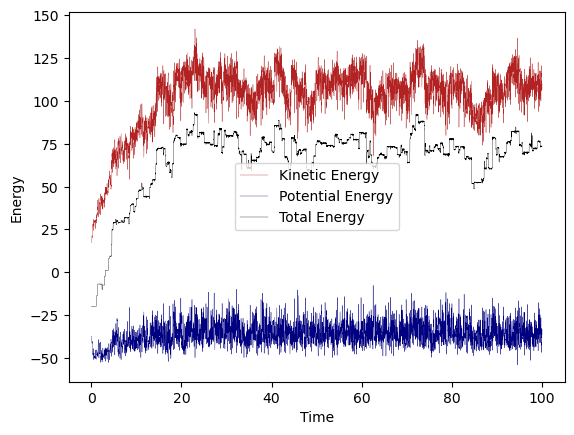

In [9]:
plt.plot(time,KE, color='firebrick', label= "Kinetic Energy", lw=0.25)  # Plot the kinetic energy
plt.plot(time, PE, color='navy', label="Potential Energy", lw=0.25)     # Plot the potential energy
plt.plot(time, (KE+PE), color='k', label="Total Energy", lw=0.25)       # Plot the total energy
plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
    
<b>Comment:</b> Notice how unlike the previous simulations with the Lennard-Jones fluid, the total energy of the system _also_ fluctuates due to the interaction between the system and the thermostat. This shows that we are simulating a "canonical" ensemble. We can now see whether we have attained out "set" temperature by looking at the probability distribution of the speeds of particles, just as in the last assignment.
    
</div>

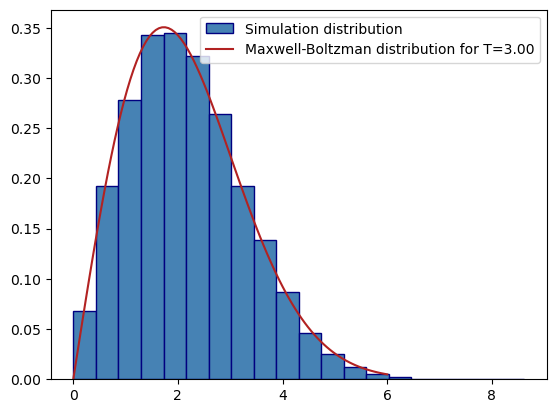

In [10]:
equilibriated_velocities = vel[time>30] # Choose a cutoff beyond which to consider the particles

equilibriated_speeds = np.sqrt(np.sum(equilibriated_velocities**2,axis=2)).flatten() # Get an array of all speeds present after t>30
temp = 0.5*np.mean(equilibriated_speeds**2) # Compute the average temperature as the mean kinetic energy (particle mass = 1)

plt.hist(equilibriated_speeds, density=True, bins=20, color='steelblue', ec='navy', label="Simulation distribution");

v_range = np.linspace(0,6,100)              # Array of speeds to plot the "theoretical" Maxwell-Boltzman distribution
plt.plot(v_range, maxwell(v_range, temp), color='firebrick', label=f"Maxwell-Boltzman distribution for T={set_T:.2f}")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


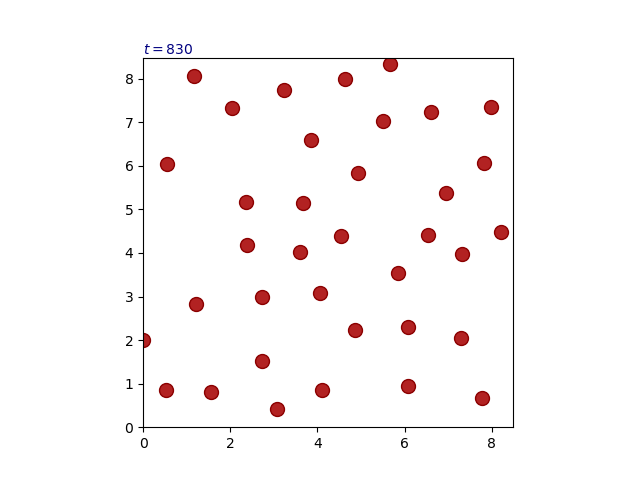

In [11]:
%matplotlib notebook
animate_particles(pos)